In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [38]:
import keras
from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.regularizers import l2

from spektral.datasets import mnist
from spektral.layers import GraphConv
from spektral.layers.ops import sp_matrix_to_sp_tensor
from spektral.utils import normalized_laplacian

from scipy.sparse import csr_matrix

In [3]:
# Parameters
l2_reg = 5e-4         # Regularization rate for l2
learning_rate = 1e-3  # Learning rate for SGD
batch_size = 32       # Batch size
epochs = 1000         # Number of training epochs
es_patience = 10     # Patience fot early stopping

In [6]:
X_train = np.load("skel_features/mnist/save/X_train.npy", allow_pickle=True)
X_test = np.load("skel_features/mnist/save/X_test.npy", allow_pickle=True)
y_train = np.load("skel_features/mnist/save/y_train.npy", allow_pickle=True)
y_test = np.load("skel_features/mnist/save/y_test.npy", allow_pickle=True)
skeleton_train = np.load("skel_features/mnist/save/skeleton_train.npy", allow_pickle=True)
skeleton_test = np.load("skel_features/mnist/save/skeleton_test.npy", allow_pickle=True)

max_len = np.max([x.shape[0] for x in np.hstack([skeleton_train, skeleton_test])])

for i in range(len(skeleton_train)):
    tmp = np.zeros((max_len))
    tmp[:len(skeleton_train[i])] = skeleton_train[i]
    skeleton_train[i] = tmp
    
for i in range(len(skeleton_test)):
    tmp = np.zeros((max_len))
    tmp[:len(skeleton_test[i])] = skeleton_test[i]
    skeleton_test[i] = tmp
    
X_train = np.vstack(X_train).reshape(60000,28,28,1)
X_test = np.vstack(X_test).reshape(10000,28,28,1)
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
skeleton_train = np.vstack(skeleton_train)
skeleton_test = np.vstack(skeleton_test)

In [52]:
# Load data
X_train, y_train, X_val, y_val, X_test, y_test, adj = mnist.load_data()
X_train, X_val, X_test = X_train[..., None], X_val[..., None], X_test[..., None]
N = X_train.shape[-2]      # Number of nodes in the graphs
F = X_train.shape[-1]      # Node features dimensionality
n_out = 10  # Dimension of the target

In [60]:
X_train.shape

(50000, 784, 1)

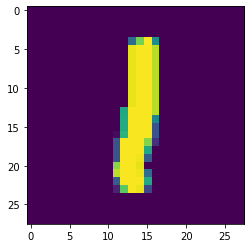

In [61]:
plt.imshow(X_train[0].reshape(28,28))

In [53]:
adj

<784x784 sparse matrix of type '<class 'numpy.float32'>'
	with 6396 stored elements in Compressed Sparse Row format>

In [40]:
fltr = normalized_laplacian(adj)

# Model definition
X_in = Input(shape=(N, F))
# Pass A as a fixed tensor, otherwise Keras will complain about inputs of
# different rank.
A_in = Input(tensor=sp_matrix_to_sp_tensor(fltr))

graph_conv = GraphConv(32,
                       activation='elu',
                       kernel_regularizer=l2(l2_reg),
                       use_bias=True)([X_in, A_in])
graph_conv = GraphConv(32,
                       activation='elu',
                       kernel_regularizer=l2(l2_reg),
                       use_bias=True)([graph_conv, A_in])
flatten = Flatten()(graph_conv)
fc = Dense(512, activation='relu')(flatten)
output = Dense(n_out, activation='softmax')(fc)

# Build model
model = Model(inputs=[X_in, A_in], outputs=output)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 784, 1)       0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (784, 784)           0                                            
__________________________________________________________________________________________________
graph_conv_7 (GraphConv)        (None, 784, 32)      64          input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
graph_conv_8 (GraphConv)        (None, 784, 32)      1056        graph_conv_7[0][0]               
          

In [41]:
# Train model
validation_data = (X_val, y_val)
model.fit(X_train,
          y_train,
          batch_size=batch_size,
          validation_data=validation_data,
          epochs=epochs,
          callbacks=[
              EarlyStopping(patience=es_patience, restore_best_weights=True)
          ])

Train on 50000 samples, validate on 10000 samples
Epoch 1/1000
17024/50000 [=========>....................] - ETA: 3:08 - loss: 0.9321 - acc: 0.7138

KeyboardInterrupt: 

In [14]:
# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate(X_test,
                              y_test,
                              batch_size=batch_size)
print('Done.\n'
      'Test loss: {}\n'
      'Test acc: {}'.format(*eval_results))

Evaluating model.
10000/10000 [==============================] - 3s 343us/step
Done.
Test loss: 0.7091315130710601
Test acc: 0.7756
